In [169]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [173]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/*data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

,jetEta,jetPhi,jetPt,jetM,jetChargedFraction,jetPTD,jetAxis2
0,0.391208,3.126895,880.629578,46.972202,0.941176,0.238104,0.041430
1,0.226281,1.619783,839.069214,27.909035,0.631579,0.254852,0.016366
2,1.215448,0.042642,1736.550293,164.827713,0.608696,0.418112,0.006629
3,-0.121109,-1.891376,453.773132,62.488964,0.771429,0.162267,0.079624
4,1.025759,3.117460,882.341492,160.383484,0.600000,0.215028,0.021459


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train', 'test']


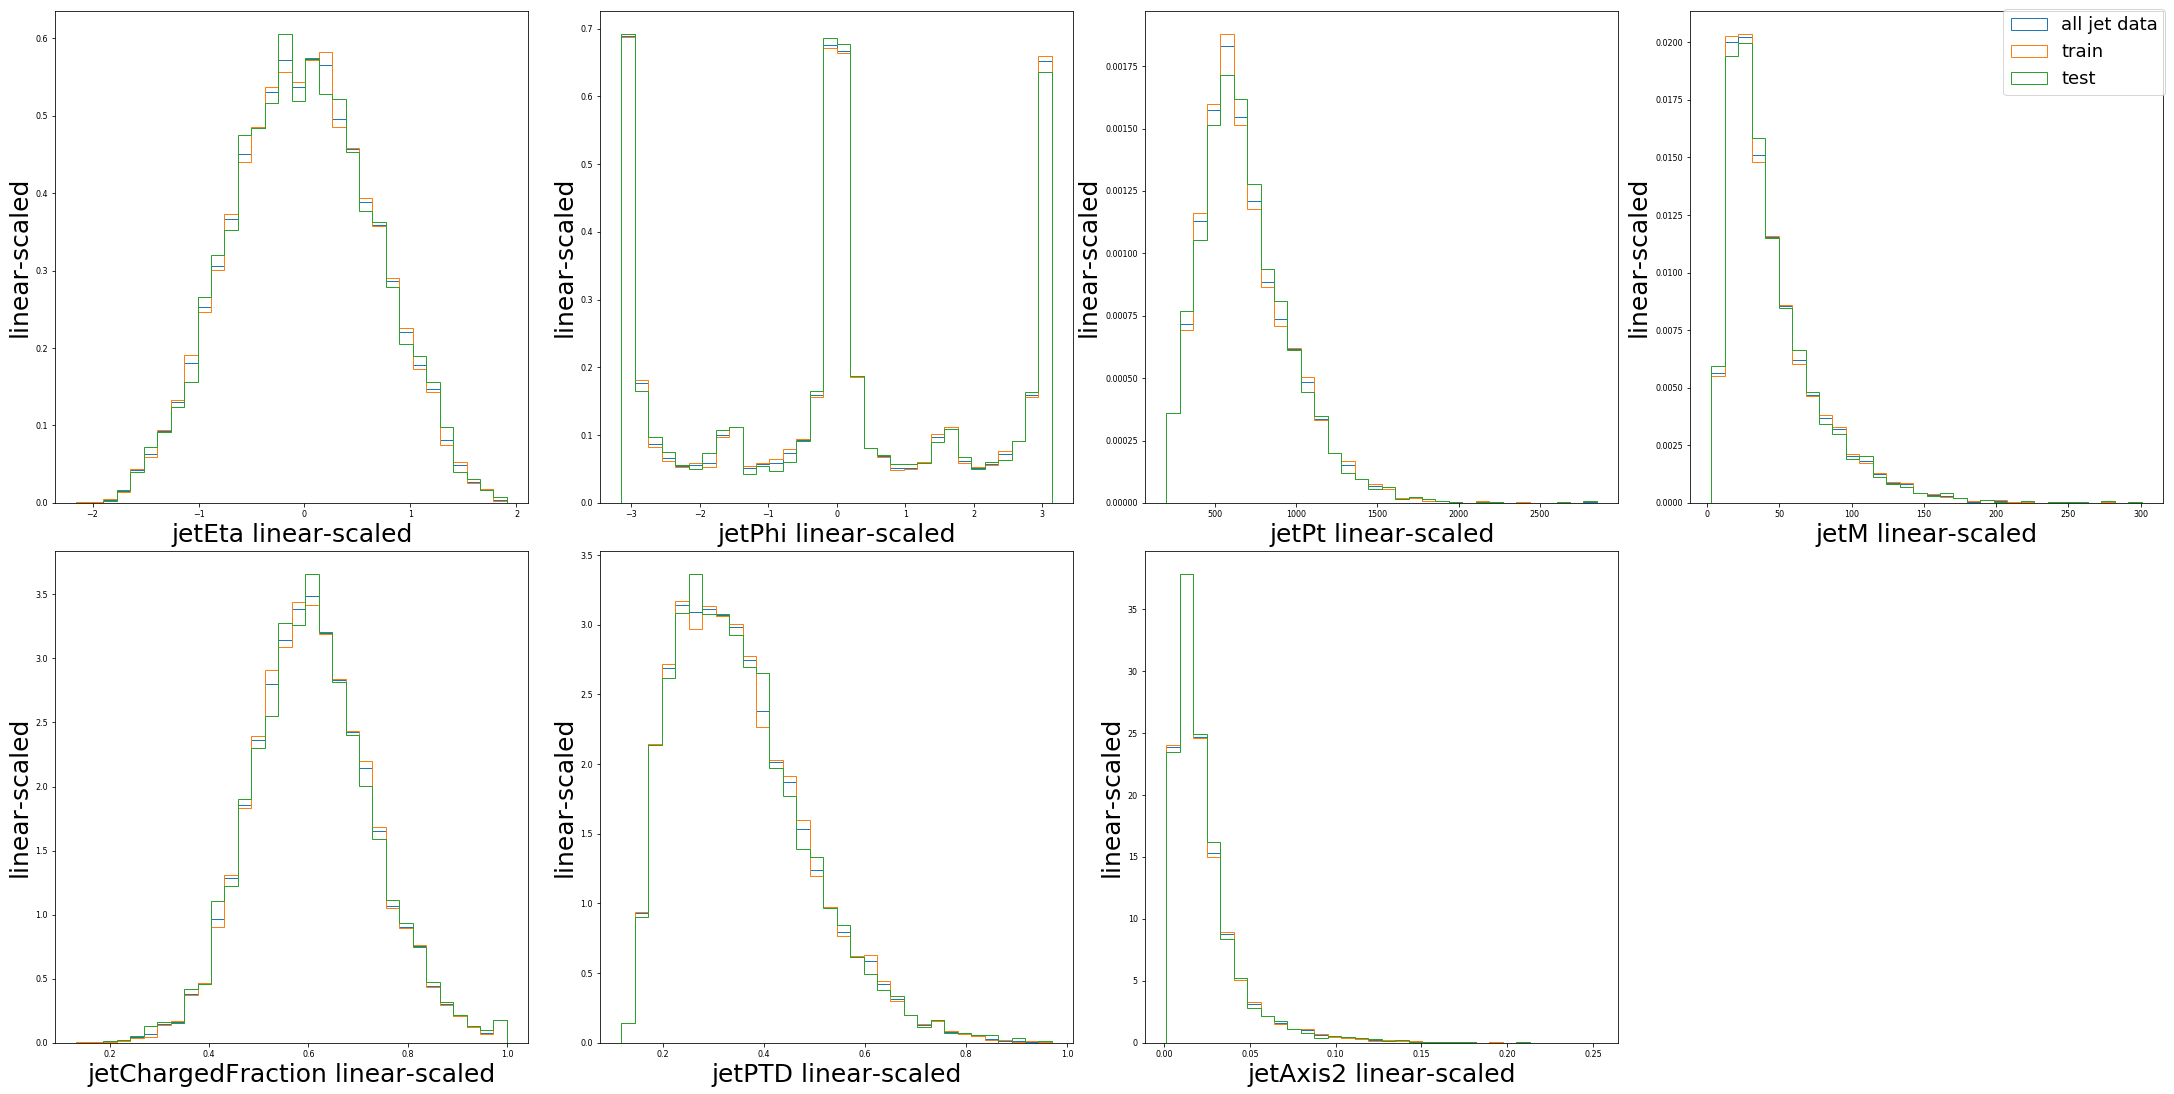

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


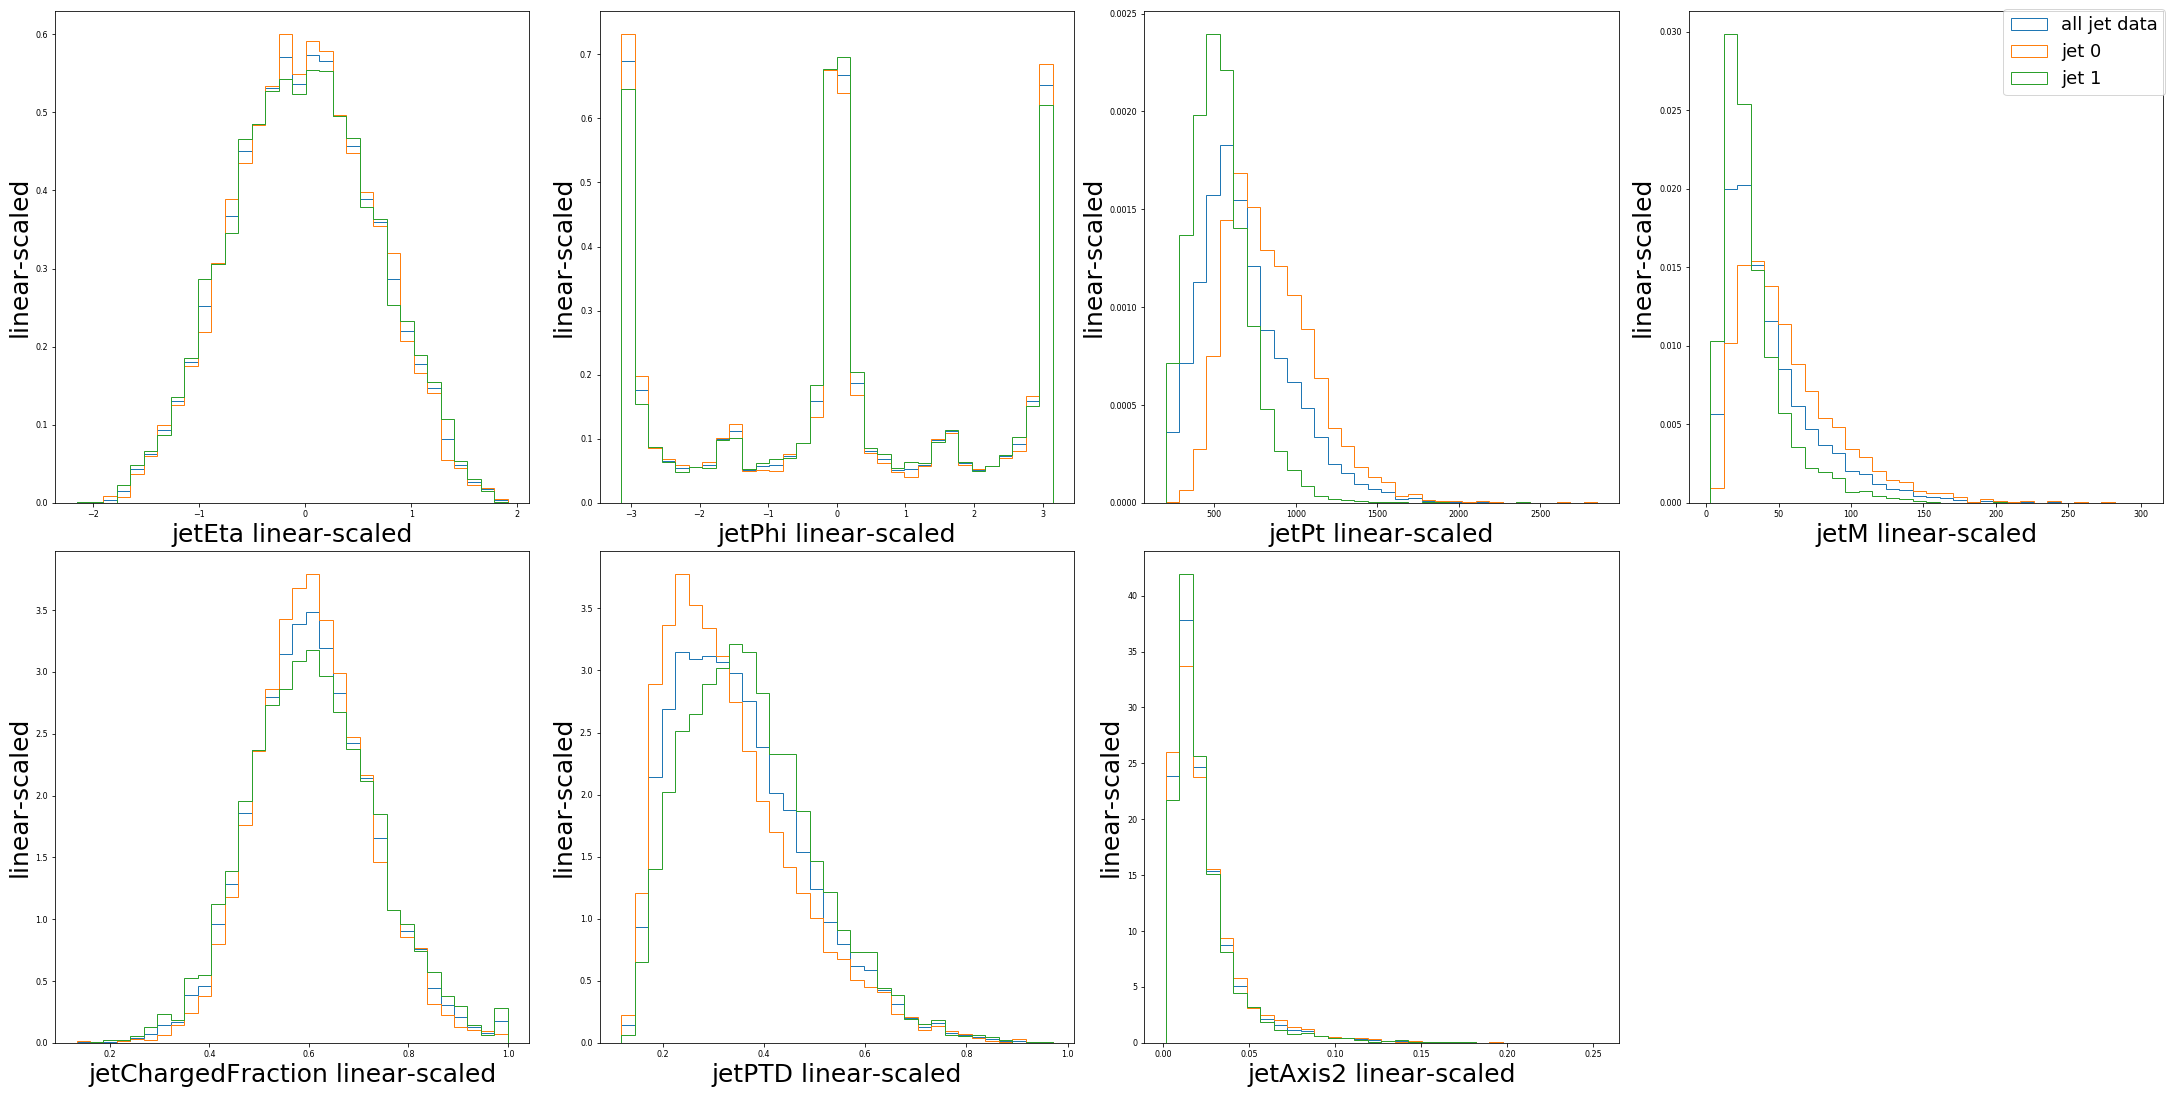

In [174]:
train, test = data.train_test_split(0.3)
data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


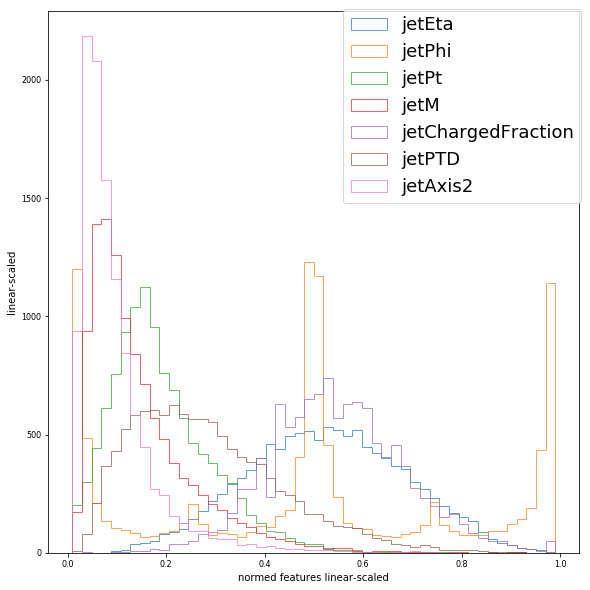

In [175]:
norm_args = {
    "norm_type": "MinMaxScaler",
    "feature_range": (0.01, 0.99)
}

norm_data = data.norm(**norm_args)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)


# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [309]:
def log_K_lognormal(x, a1, a2, a3):
    return 0.5*((K.log(x) - a1)/a2)**2. - K.log(a3/(a2*x*np.sqrt(2.0*np.pi)))

def log_K_gaussian(x, a1, a2):
    return 0.5*((x - a1)/a2)**2. - K.log(1.0/(2.*a2*np.sqrt(2.0*np.pi)))

def log_K_phi_pdf(x, frac, sig1, sig2):
    return -K.log(K_phi_pdf(x, frac, sig1, sig2))
 
def K_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    mask = K.cast(K.greater(x, 0.), 'float32')
    return mask*a3/(x*a2*K.sqrt(K.variable(2.*np.pi)))*K.exp(-(K.log(x) - a1)**2./(2.*a2*a2)) + (1. - mask)*10e-5
      
def K_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*K.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def K_phi_pdf(x, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    ratio = K_gaussian(0, 0, sig1)/K_gaussian(0, 0, sig2)
    f1 = frac/ratio
    f2 = frac*ratio
    ret = f1*K_gaussian(x, 0.01, sig1) + f2*K_gaussian(x, .255, sig2) + f1*K_gaussian(x, .5, sig1) + f2*K_gaussian(x, .745, sig2) + f1*K_gaussian(x, .99, sig1)
    mask = K.cast(K.greater(ret, 0.), "float32")
    return ret*mask + (1. - mask)*10e-8

def K_custom_loss(true, pred):
    mus, sigmas, skews, others = K.mean(pred[:,0:6], axis=0), K.mean(pred[:,6:14], axis=0), K.mean(pred[:,14:18], axis=0), K.mean(pred[:,18:19], axis=0) 
    loss = (
        log_K_gaussian(
            true[:,0],
            mus[0], sigmas[0]
        )
    )
    loss = loss + (
        log_K_phi_pdf(
            true[:,1],
            others[0], sigmas[1], sigmas[2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,2],
            mus[1], sigmas[3], skews[0],
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,3],
            mus[2], sigmas[4], skews[1]
        )
    )
    loss = loss + (
        log_K_gaussian(
            true[:,4],
            mus[3], sigmas[5]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,5],
            mus[4], sigmas[6], skews[2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,6],
            mus[5], sigmas[7], skews[3]
        )
    )
    return K.max(loss)

In [310]:
def min_layer(inputs, size, name, activation="linear", min_value=10e-6, offset=0):
    set_to = min_value + offset
    ret = keras.layers.Dense(size, activation="linear")(inputs)
    def lambda_func(s, m):
        def subfunc(x):
            mask = K.cast(K.greater(x, m), 'float32')
            return x*mask + (1. - mask)*s
        return subfunc
    
    return keras.layers.Lambda(
        lambda_func(set_to, min_value), output_shape=(size,), name=name
    )(ret)
    

inputs = keras.layers.Input(shape=(7,), name="input")
encoded = keras.layers.Dense(30, activation="relu", name="dense_encode")(inputs)
encoded = keras.layers.Dense(5, activation="relu", name="encoded")(encoded)
encoder = keras.Model(inputs=inputs, outputs=encoded, name="encoder")

decoder_inputs = keras.layers.Input(shape=(5,), name="decoder_inputs")
decoded = keras.layers.Dense(30, activation="relu", name="dense_decode")(decoder_inputs)
# decoded = keras.layers.Dense(20, activation="linear")(decoded)
mus = keras.layers.Dense(6, activation="linear", name="mus")(decoded)
sigmas = min_layer(decoded, 8, "sigmas")
skews = min_layer(decoded, 4, "skews")
others = min_layer(decoded, 1, "others")
decoded = keras.layers.concatenate([mus, sigmas, skews, others], axis=-1)


decoder = keras.Model(inputs=decoder_inputs, outputs=decoded, name="decoder")

autoencoder = keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)), name="autoencoder")
autoencoder.compile(optimizer="adam", loss=K_custom_loss)

In [311]:
name = "custom_5_test_prime"
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/custom", name))

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'custom_5_test_prime.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'custom_5_test_prime.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'custom_5_test_prime.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'custom_5_test_prime.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'custom_5_test_prime.h5'


... and the model summaries:

In [312]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7)                 0         
_________________________________________________________________
dense_encode (Dense)         (None, 30)                240       
_________________________________________________________________
encoded (Dense)              (None, 5)                 155       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


decoder summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 5)            0                                            
___________________________________________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [313]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [315]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

train_pad = np.pad(train_norm.data, ((0,0),(0,19 - train_norm.data.shape[1])), 'constant')
test_pad = np.pad(test_norm.data, ((0,0),(0,19 - test_norm.data.shape[1])), 'constant')

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_pad,
    y_test=test_pad,
#     y_train=np.ones((train_norm.shape[0], 20)),
#     y_test=np.ones((test_norm.shape[0], 20)),
    optimizer="adam",
    loss=K_custom_loss,
    epochs=60,
    model=autoencoder,
    metrics=[],
    force=True,
    batch_size=128,
    use_callbacks=False,
    learning_rate=0.00025,
)

train_shell :: using model passed as function argument
train_shell :: TRAINING EPOCH 120/180
Train on 7865 samples, validate on 3371 samples
Epoch 121/121
61/61 [==============================] - 7s 114ms/step - loss: 136.0326 - val_loss: 97.8059
train_shell :: TRAINING EPOCH 121/180
Train on 7865 samples, validate on 3371 samples
Epoch 122/122
61/61 [==============================] - 1s 15ms/step - loss: 50.7476 - val_loss: 50.0170
train_shell :: TRAINING EPOCH 122/180
Train on 7865 samples, validate on 3371 samples
Epoch 123/123
61/61 [==============================] - 1s 15ms/step - loss: 27.7866 - val_loss: 32.6065
train_shell :: TRAINING EPOCH 123/180
Train on 7865 samples, validate on 3371 samples
Epoch 124/124
61/61 [==============================] - 1s 16ms/step - loss: 16.7675 - val_loss: 22.4454
train_shell :: TRAINING EPOCH 124/180
Train on 7865 samples, validate on 3371 samples
Epoch 125/125
61/61 [==============================] - 1s 16ms/step - loss: 9.4703 - val_loss: 15

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

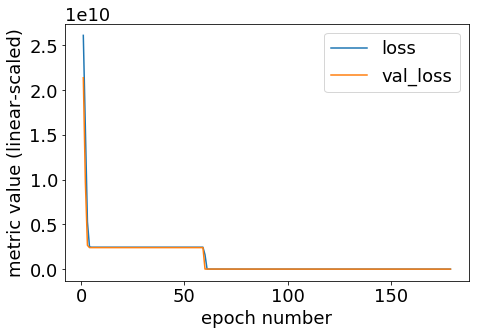

In [316]:
instance.plot_metrics(fnmatch_criteria="*loss", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [286]:
def np_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return a3/(x*a2*np.sqrt(2.*np.pi))*np.exp(-(np.log(x) - a1)**2./(2.*a2*a2))
      
def np_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*np.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def np_phi_pdf(x, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    ratio = np_gaussian(0, 0, sig1)/np_gaussian(0, 0, sig2)
    f1 = frac/ratio
    f2 = frac*ratio
    ret = f1*np_gaussian(x, 0.01, sig1) + f2*np_gaussian(x, .255, sig2) + f1*np_gaussian(x, .5, sig1) + f2*np_gaussian(x, .745, sig2) + f1*np_gaussian(x, .99, sig1)
    mask = np.where(ret > 0.)[0].astype(float)
    return ret*mask + (1. - mask)*10e-8


def np_phi_gaussians(x, dist, frac, sig1, sig2):
    f1 = 1./frac
    f2 = frac
    return  np.asarray([f1*np_gaussian(x, 0, sig1), f2*np_gaussian(x, 1.*dist, sig2), f1*np_gaussian(x, 2.*dist, sig1), f2*np_gaussian(x, 3.*dist, sig2), f1*np_gaussian(x, 4.*dist, sig1)])

def get_probabilities(true, pred):
    ret = []
    mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]
    ret.append(np_gaussian(true[:,0], mus[:,0], sigmas[:,0]))
    ret.append(np_phi_pdf(true[:,1], others[:,0], sigmas[:,1], sigmas[:,2]))
    ret.append(np_lognormal(true[:,2], mus[:,1], sigmas[:,3], skews[:,0]))
    ret.append(np_lognormal(true[:,3], mus[:,2], sigmas[:,4], skews[:,1]))
    ret.append(np_gaussian(true[:,4], mus[:,3], sigmas[:,5]))
    ret.append(np_lognormal(true[:,5], mus[:,4], sigmas[:,6], skews[:,2]))
    ret.append(np_lognormal(true[:,6], mus[:,5], sigmas[:,7], skews[:,3]))
    return np.asarray(ret)

def get_dist(x, pred):
    ret = np.empty((7, x.shape[0]))
    mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
    ret[0] = np_gaussian(x, mus[0], sigmas[0])
    ret[1] = np_phi_pdf(x, others[0], sigmas[1], sigmas[2])
    ret[2] = np_lognormal(x, mus[1], sigmas[3], skews[0])
    ret[3] = np_lognormal(x, mus[2], sigmas[4], skews[1])
    ret[4] = np_gaussian(x, mus[3], sigmas[5])
    ret[5] = np_lognormal(x, mus[4], sigmas[6], skews[2])
    ret[6] = np_lognormal(x, mus[5], sigmas[7], skews[3])
    return ret

def get_all_lh(Pred, rng=(0.01, 0.99), points=1000):
    x = np.linspace(rng[0], rng[1], points)
    lret = []
    for pred in Pred:
        mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
        ret = []
        ret.append(np_gaussian(x, mus[0], sigmas[0]))
        ret.append(np_phi_pdf(x, others[0], sigmas[1], sigmas[2]))
        ret.append(np_lognormal(x, mus[1], sigmas[3], skews[0]))
        ret.append(np_lognormal(x, mus[2], sigmas[4], skews[1]))
        ret.append(np_gaussian(x, mus[3], sigmas[5]))
        ret.append(np_lognormal(x, mus[4], sigmas[6], skews[2]))
        ret.append(np_lognormal(x, mus[5], sigmas[7], skews[3]))
        lret.append(ret)
    return x,np.asarray(lret)

def get_avg_lh(Pred, rng=(0.01, 0.99), points=1000):
    x = np.linspace(rng[0], rng[1], points)
    pred = Pred.mean(axis=0)
    mus, sigmas, skews, others = pred[0:6], pred[6:14], pred[14:18], pred[18:20]
    ret = []
    ret.append(np_gaussian(x, mus[0], sigmas[0]))
    ret.append(np_phi_pdf(x, others[0], sigmas[1], sigmas[2]))
    ret.append(np_lognormal(x, mus[1], sigmas[3], skews[0]))
    ret.append(np_lognormal(x, mus[2], sigmas[4], skews[1]))
    ret.append(np_gaussian(x, mus[3], sigmas[5]))
    ret.append(np_lognormal(x, mus[4], sigmas[6], skews[2]))
    ret.append(np_lognormal(x, mus[5], sigmas[7], skews[3]))
    
    return x,np.asarray(ret)
    
    
pred = autoencoder.predict(test_norm.data)

weights = get_probabilities(test_norm.data, pred).T
x,ll = get_avg_lh(pred)


from sklearn.preprocessing import MinMaxScaler

weights = MinMaxScaler().fit_transform(weights)

# for i,w in enumerate(weights.T):
# #     plt.hist(w, bins=30, normed=1, histtype='step')

#     plt.hist(test_norm.data[:,i], weights=w, bins=50, normed=1, histtype='step', label='pred')
#     plt.hist(test_norm.data[:,i], bins=50, normed=1, histtype='step', label='true')
#     plt.legend()
#     plt.show()
# # print pred.shape
# # lplot = ll.mean(axis=0)
# for i,l in enumerate(lplot):
#     bc, bins = np.histogram(norm_data.data[:,i], bins=50, normed=1)
#     plt.scatter(x, l/l.max())
#     plt.step(bins[1:], bc/bc.max())
#     plt.show()

In [287]:
x = np.linspace(0.01, .99, 100)
np.diff(x)

print x.shape
for p in pred:
    pdf = get_dist(x, p)
    pdf
#     print pdf.shape

(100,)


In [319]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), headers=["val {}".format(i+1) for i in range(5)], name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), headers=["val {}".format(i+1) for i in range(5)], name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


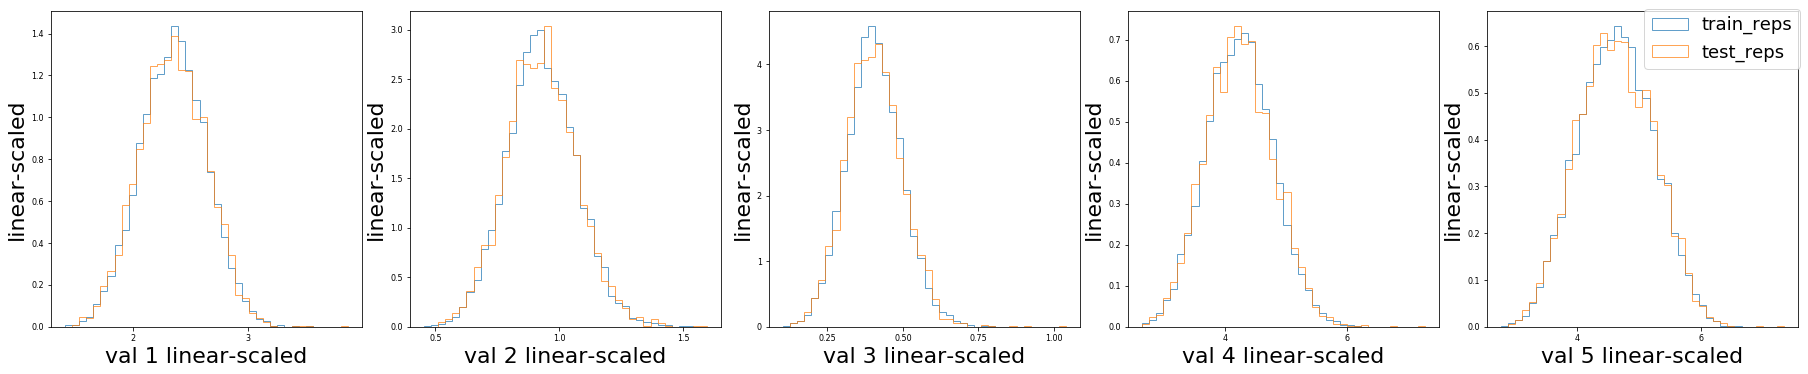

In [320]:
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)

In [633]:
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

data_table :: plotting distrubution(s) for table(s) ['errors']


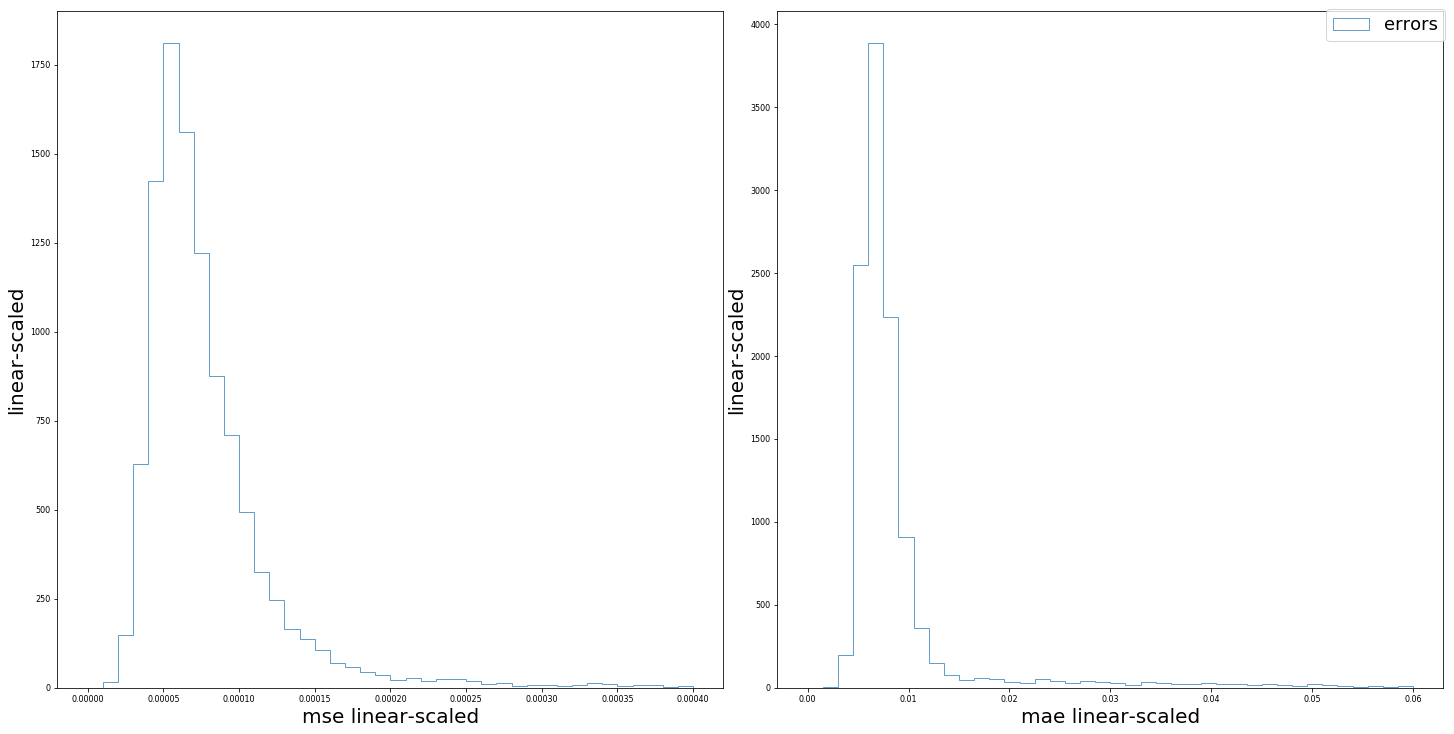

In [643]:
errors.plot(figsize=(20,10), bins=40, rng=((0,0.0004), (0, 0.06)), fontsize=20)

In [646]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['normal', 'outliers (top 0.01)']


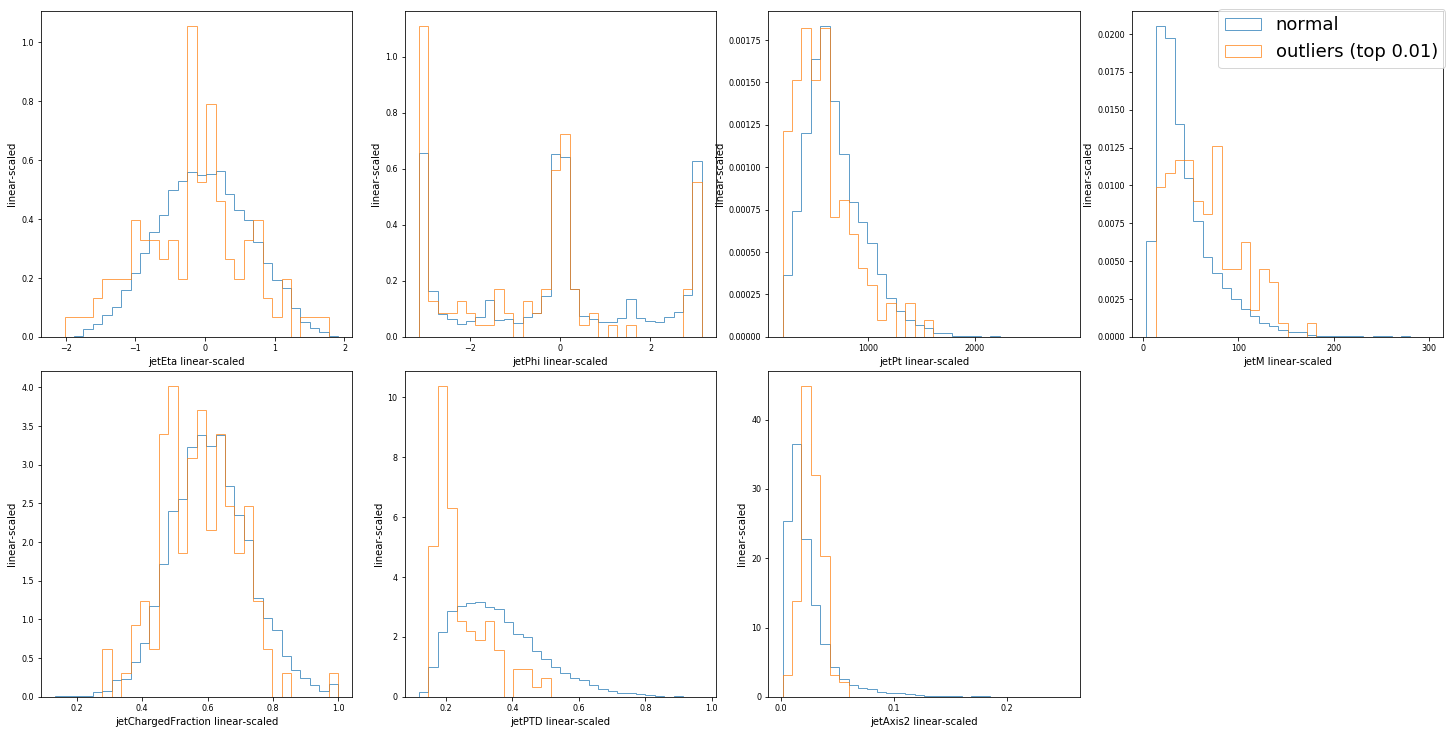

In [647]:
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
reg.plot(out, normed=1, bins=30, figsize=(20,10))